In [2]:
%reload_ext autoreload
%autoreload 2
from helpers import *
from spice_net import *
import numpy as np
import matplotlib.pyplot as plt
from PySpice.Logging.Logging import setup_logging

#### Generate the dataset

In [5]:
# Generate N random points
N = 100
split = 0.6
pts = np.random.rand(N, 2)* 2 - 1

# Split into training and training datasets
np.random.shuffle(pts)
train_x, test_x = pts[:int(N*split),:], pts[int(N*split):,:]

# Generate categories with nonlinear decision boundary
m = 1
b=0
decision_bound = lambda x: m*x**2+b

# mask = np.logical_xor(pts[:, 1] > 0, pts[:, 0] > 0)
mask = pts[:, 1] > decision_bound(pts[:, 0])
pos = pts[mask]
neg = pts[~mask]
train_y = np.vstack((mask[:int(N*split)], ~mask[:int(N*split)])).T.astype(int)
test_y = np.vstack((mask[int(N*split):], ~mask[int(N*split):])).T.astype(int)

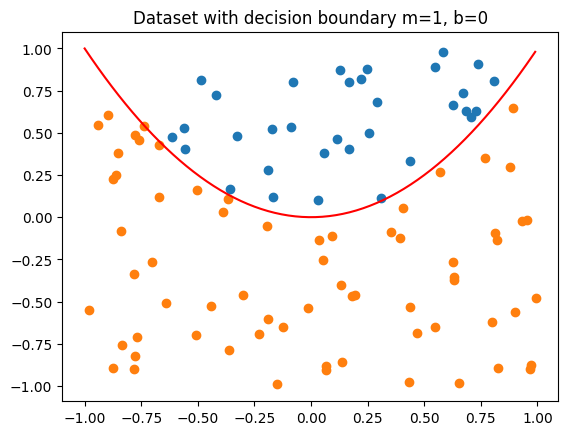

In [6]:
# Visualize dataset
plt.scatter(*pos.T)
plt.scatter(*neg.T)
xs = np.arange(-1, 1, 0.01)
plt.plot(xs, decision_bound(xs), 'r')
plt.title(fr'Dataset with decision boundary m={round(m, 3)}, b={round(b, 3)}')
plt.show()

#### Generate random linear resistive network

In [9]:
# Parameters
nodes = 15

avg_deg = 4
edge_prob =  avg_deg / nodes
edge_prob =  1

diode_prob = .8

con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=False)
diodes, res = 0, 0
for u, v in con_graph.edges():
    if np.random.rand() < diode_prob:
        diodes += 1
        con_graph[u][v]['type'] = 'diode'
        con_graph[u][v]['weight'] = 1. #/np.random.rand() 
    else:
        con_graph[u][v]['type'] = 'resistor'
        con_graph[u][v]['weight'] = 1 #./np.random.rand()
        res += 1

print('Num edges:', diodes + res)
print('Num purely resistor:', res)
print('Num diodes:', diodes)

in_nodes = 2
out_nodes = 2
node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])
node_cfg

Num edges: 105
Num purely resistor: 18
Num diodes: 87


(array([[10,  3],
        [13,  1]]),
 array([[11,  7],
        [14,  5]]))

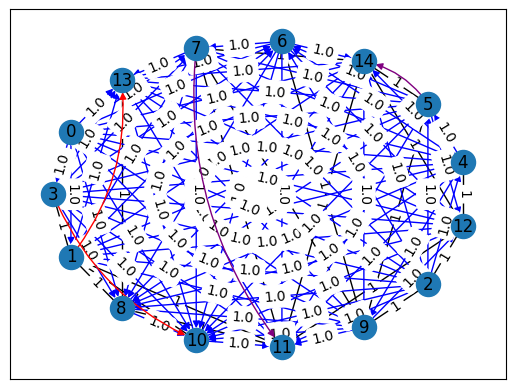

In [10]:
net = NonLinearNetwork('untrained_class', con_graph, node_cfg)

visualize(net)

#### Train both networks

In [11]:
augmented = np.hstack((train_x, np.ones((train_x.shape[0], 1))))
dset = train_x

In [12]:
# Train linear network
epochs =  100

alpha = 1e-1
eta = 1e-3
gamma = alpha / eta / 2

trained = net.copy('classifier')
trained, loss, updates, weights = train(trained, dset, train_y, epochs, gamma=gamma, eta=eta)

Note: can't find the initialization file spinit.
Unsupported Ngspice version 38


Epoch 1: 0.42808243909957766
Epoch 2: 0.3975577916188645
Epoch 3: 0.3805269379378185
Epoch 4: 0.37886151790720773
Epoch 5: 0.37773676455925886
Epoch 6: 0.376424328782523
Epoch 7: 0.374079375346049
Epoch 8: 0.3693662079600804
Epoch 9: 0.37188044470465653
Epoch 10: 0.3593888971860805
Epoch 11: 0.339409435425348
Epoch 12: 0.34893289070181516
Epoch 13: 0.33701446116715


Note: Starting dynamic gmin stepping
Trying gmin =   1.0000E-03 Note: One successful gmin step
Trying gmin =   1.0000E-04 Note: One successful gmin step
Trying gmin =   1.0000E-05 Note: One successful gmin step
Trying gmin =   1.0000E-06 Note: One successful gmin step
Trying gmin =   1.0000E-07 Note: One successful gmin step
Trying gmin =   1.0000E-08 Note: One successful gmin step
Trying gmin =   1.0000E-09 Note: One successful gmin step
Trying gmin =   1.0000E-10 Note: One successful gmin step
Trying gmin =   1.0000E-11 Note: One successful gmin step
Trying gmin =   1.0000E-12 Note: One successful gmin step
Trying gmin =   1.0000E-12 Note: One successful gmin step
Note: Dynamic gmin stepping completed


NgSpiceCommandError: Command 'run' failed

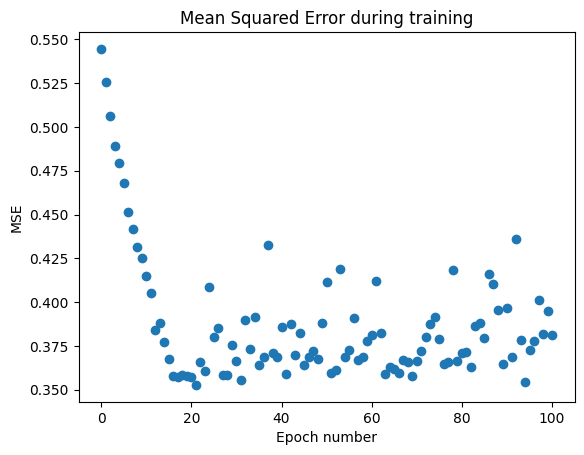

In [ ]:
plt.scatter(np.arange(loss.size), loss)
plt.title('Mean Squared Error during training')
plt.xlabel('Epoch number')
plt.ylabel('MSE')
plt.show()

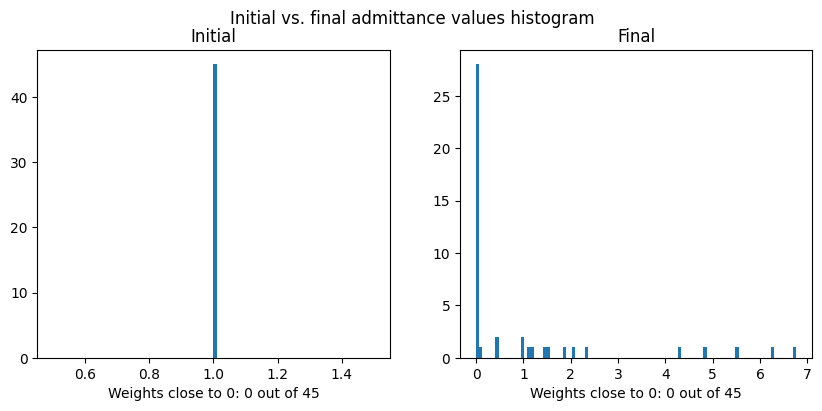

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(1./weights[0, -1], bins=100)
axs[0].set_title('Initial')
axs[0].set_xlabel(f'Weights close to 0: {np.sum(np.isclose(weights[0, -1], 1./trained.epsilon))} out of {weights[0, -1].size}')
axs[1].hist(1./weights[-1, -1], bins=100)
axs[1].set_title('Final')
axs[1].set_xlabel(f'Weights close to 0: {np.sum(np.isclose(weights[0, -1], 1./trained.epsilon))} out of {weights[0, -1].size}')
fig.suptitle('Initial vs. final admittance values histogram')
plt.show()

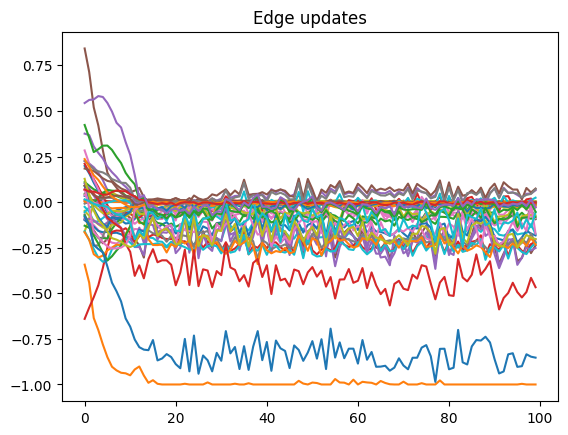

In [ ]:
# plt.plot(updates.reshape(-1, updates.shape[-1]))
# plt.plot(np.clip(updates.reshape(-1, updates.shape[-1]), -.5, .5))
plt.plot(np.clip(updates.sum(axis=1), -1, 1))
plt.title('Edge updates')
plt.show()

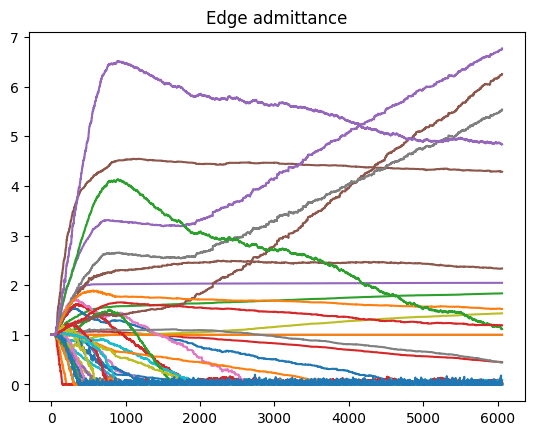

In [ ]:
# plt.plot(1./weights.reshape(-1, weights.shape[-1]))
plt.plot(np.clip(1./weights.reshape(-1, weights.shape[-1]), -1, np.inf))
plt.title('Edge admittance')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))


untrained_sol = np.argmax(net.predict(train_x).squeeze(), axis=1)
trained_sol = np.argmax(trained.predict(train_x).squeeze(), axis=1)
analytic_sol = np.argmax(train_x @ np.linalg.inv(train_x.T @ train_x) @ train_x.T @ train_y, axis=1)
# xs = np.linspace(0, 1, 10)

axs[0].scatter(*train_x[untrained_sol.astype(bool)].T)
axs[0].scatter(*train_x[~untrained_sol.astype(bool)].T)
# axs[0].plot(xs, decision_bound(xs), 'r')
axs[0].set_xlabel(f'Accuracy: {np.sum(train_y[:,1] == untrained_sol) / len(train_x):.3f}')

axs[1].scatter(*train_x[trained_sol.astype(bool)].T)
axs[1].scatter(*train_x[~trained_sol.astype(bool)].T)
# axs[1].plot(xs, decision_bound(xs), 'r')
axs[1].set_xlabel(f'Accuracy: {np.sum(train_y[:,1] == trained_sol) / len(train_x):.3f}')

axs[2].scatter(*train_x[analytic_sol.astype(bool)].T)
axs[2].scatter(*train_x[~analytic_sol.astype(bool)].T)
# axs[2].plot(xs, decision_bound(xs), 'r')
axs[2].set_xlabel(f'Accuracy: {np.sum(train_y[:,1] == analytic_sol) / len(train_x):.3f}')

fig.suptitle(f'Network outputs for trained, untrained, and optimum linear')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))


untrained_sol = np.argmax(net.predict(test_x).squeeze(), axis=1)
trained_sol = np.argmax(trained.predict(test_x).squeeze(), axis=1)
analytic_sol = np.argmax(test_x @ np.linalg.inv(train_x.T @ train_x) @ train_x.T @ train_y, axis=1)
# xs = np.linspace(0, 1, 10)

axs[0].scatter(*test_x[untrained_sol.astype(bool)].T)
axs[0].scatter(*test_x[~untrained_sol.astype(bool)].T)
axs[0].plot(xs, decision_bound(xs), 'r')
axs[0].set_xlabel(f'Accuracy: {np.sum(test_y[:,1] == untrained_sol) / len(test_x):.3f}')

axs[1].scatter(*test_x[trained_sol.astype(bool)].T)
axs[1].scatter(*test_x[~trained_sol.astype(bool)].T)
axs[1].plot(xs, decision_bound(xs), 'r')
axs[1].set_xlabel(f'Accuracy: {np.sum(test_y[:,1] == trained_sol) / len(test_x):.3f}')

axs[2].scatter(*test_x[analytic_sol.astype(bool)].T)
axs[2].scatter(*test_x[~analytic_sol.astype(bool)].T)
axs[2].plot(xs, decision_bound(xs), 'r')
axs[2].set_xlabel(f'Accuracy: {np.sum(test_y[:,1] == analytic_sol) / len(test_x):.3f}')

fig.suptitle(f'Network outputs for trained, untrained, and optimum linear')
plt.show()

NameError: name 'plt' is not defined

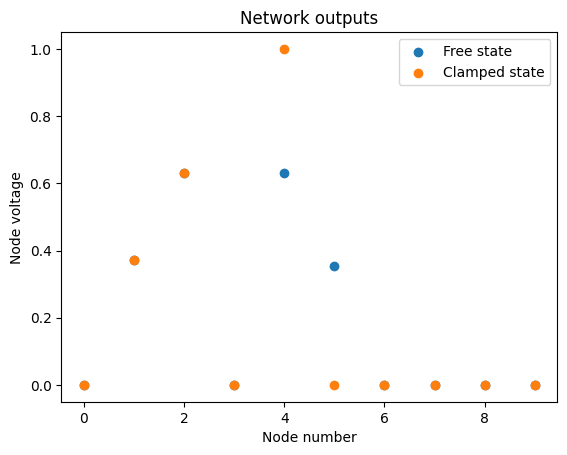

In [ ]:
# Compare free and clamped results on a single input
plt.scatter(np.arange(10), trained.solve(train_x[0]))
plt.scatter(np.arange(10), trained.solve(train_x[0], train_y[0]))
plt.title('Network outputs')
plt.xlabel('Node number')
plt.ylabel('Node voltage')
plt.legend(['Free state', 'Clamped state'])